In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 4A: DFC expression in case only vs. ctrl-only genes, 2 example time points
* Figure 4B: DFC expression in case only vs. ctrl-only genes, all time points
* Figure 4C: HDAC2 allele freqs
* Figure 4D: HDAC2 eSTR
* Figure 4E: Expression across time points

**Supplementary Figures:** 
* Supplementary Figure 13: eSTR QQ plot 
* Supplementary Figure 14: Example allele frequency plots

In [1]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import seaborn as sns

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"

# Output path info
OUTDIR = "pdfs/"

# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

In [3]:
# Load expression data
coldata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/columns_metadata.csv")
rowdata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/rows_metadata.csv")
brainspan = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/expression_matrix.csv",
                  names=coldata["column_num"])
brainspan.index = list(rowdata["gene_symbol"])

In [4]:
# Load per-locus mutation info
LOCFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.locus_stats.tab"
data = pd.read_csv(LOCFILE, delim_whitespace=True)

# Convert locus file to hg19
coords = pd.read_csv("/storage/mgymrek/ssc-denovos/for-gtex/ssc_hg19_coords.bed", sep="\t",
                     names=["chrom1","pos_hg19","end_hg19","coords_hg38"])
coords = coords[coords["chrom1"].apply(lambda x: "X" not in x and "Y" not in x and "_" not in x)]
coords["chrom"] = coords["chrom1"].apply(lambda x: GetChrom(x))
coords["pos"] = coords["coords_hg38"].apply(lambda x: int(x.split(":")[1]))
data = pd.merge(data, coords[["chrom","pos","pos_hg19"]], on=["chrom","pos"])

# Figure 4A, B: Expression of case-only vs. ctrl-only genes

In [81]:
# Get case-only and ctrl-only genes
def GetGene(x):
    if x["FEATURE-CODING"]>0: return x["gene-coding"]
    if x["FEATURE-UTR5"]>0: return x["gene-utr5"]
    if x["FEATURE-UTR3"]>0: return x["gene-utr3"]
    else: return x["TSS_GENE"]

usecols = (adata["FEATURE-PROMOTER5kb"]>0) | (adata["FEATURE-CODING"]>0) | (adata["FEATURE-UTR5"]>0) #| (adata["FEATURE-FETALBRAINTSS"]>0)
adata["gene"] = adata.apply(GetGene, 1)
genes_cases = set(adata[(adata["phenotype"]==2) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
genes_ctrls = set(adata[(adata["phenotype"]==1) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
both = genes_cases.intersection(genes_ctrls)
genes_cases = genes_cases.difference(both)
genes_ctrls = genes_ctrls.difference(both)

# Get expression for each
means_cases = []
means_ctrls = []
medians_cases = []
medians_ctrls = []
pvals = []

for i in range(1, (brainspan.shape[1])+1):
    cols = i
    mean_ctrl = np.mean(brainspan.loc[genes_ctrls,cols])
    mean_case = np.mean(brainspan.loc[genes_cases,cols])
    means_cases.append(mean_case)
    means_ctrls.append(mean_ctrl)
    median_ctrl = np.median(brainspan.loc[genes_ctrls,cols])
    median_case = np.median(brainspan.loc[genes_cases,cols])
    medians_cases.append(median_case)
    medians_ctrls.append(median_ctrl)
    expr_ctrl = np.log(brainspan.loc[genes_ctrls,cols]+0.01)
    expr_case = np.log(brainspan.loc[genes_cases,cols]+0.01)
    pvals.append(scipy.stats.ks_2samp(expr_ctrl, expr_case, alternative="greater")[1])
    
coldata["mean_case"] = means_cases
coldata["mean_ctrl"] = means_ctrls
coldata["median_case"] = medians_cases
coldata["median_ctrl"] = medians_ctrls
coldata["pval"] = pvals

In [217]:
#coldata.sort_values("pval")
len(genes_ctrls)
len(genes_cases)

268

In [224]:
10**-1*pvaldata

array([[       nan,        nan, 0.20837602, 0.17346509,        nan,
        0.14084877, 0.10244098, 0.17484706,        nan, 0.16418673,
        0.1416185 , 0.14231529, 0.16418673, 0.16385221],
       [0.17235421, 0.18126139, 0.27848843, 0.19083927, 0.17116857,
        0.1390846 , 0.16896499, 0.21359222,        nan, 0.15775507,
        0.25269401,        nan, 0.1536172 , 0.18540552],
       [       nan,        nan,        nan, 0.15193091, 0.17227571,
        0.12454788, 0.16169606, 0.22565698, 0.19984474, 0.18807504,
        0.17864287, 0.16144431, 0.18346705, 0.186558  ],
       [0.13056057, 0.3093009 , 0.18887369, 0.24867641, 0.12805469,
        0.16828625, 0.11859705, 0.13671644, 0.09679748, 0.17296365,
        0.17751553, 0.14945756, 0.11342311, 0.16820737],
       [0.14882373, 0.23552125, 0.22406209, 0.21366756, 0.15824121,
        0.11329874, 0.16318494, 0.15458782,        nan, 0.16711323,
        0.26125722, 0.20822237, 0.19672043, 0.17450071],
       [       nan,        nan, 0.1

0.008245933068729786
0.018422522923422075
0.039040226333495104
0.09453446217985337
0.017845525959747664
0.022810389121792358
0.03835438521289117
0.03774392998026488
0.022810389121792358
0.02298676781840411
0.018899828739808024
0.015395226462763792
0.0016410268045965607
0.012348304005783196
0.019422912252226074
0.04065874627216735
0.02043384725847855
0.007312701483082113
0.026451438526678667
0.0029720758976261303
0.029095643747288742
0.013994094784443432
0.03024759707327949
0.018934023140615933
0.056822615088924486
0.024156798196534206
0.0055389857109951
0.010035813318824015
0.013159810716085756
0.01635201673097456
0.02429723738381592
0.014632869268184034
0.013627618479568523
0.04947597335335572
0.000807218313790257
0.012920018860297902
0.0032601370642538602
0.052414701836994246
0.020755706735481154
0.06516725991661217
0.042937390575001545
0.10765276995953248
0.01863646178175699
0.016782037443288766
0.0320202281559036
0.07341231104292578
0.02079343742703261
0.03249096970839639
0.0044135

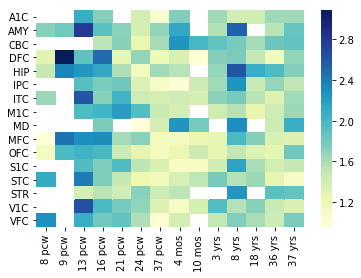

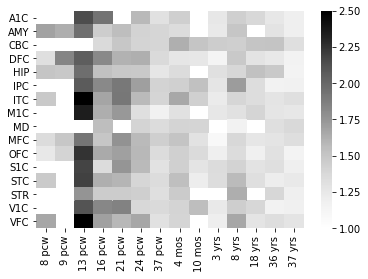

In [225]:
timepoints = ["8 pcw", "9 pcw", "13 pcw", "16 pcw", "21 pcw", "24 pcw", "37 pcw",
             "4 mos", "10 mos", "3 yrs", "8 yrs","18 yrs", "36 yrs", "37 yrs"]
structures = sorted(set(coldata["structure_acronym"]))
structures = [item for item in structures if item not in ["CB","LGE","CGE","URL","DTH","M1C-S1C","Ocx",
                                                         "MGE","PCx","TCx"]]

fcdata = np.zeros((len(structures), len(timepoints)))
pvaldata = np.zeros((len(structures), len(timepoints)))

coldata["FC"] = coldata.apply(lambda x: x["median_case"]/x["median_ctrl"], 1)

for i in range(len(structures)):
    for j in range(len(timepoints)):
        plotdata = coldata[(coldata["structure_acronym"]==structures[i]) & 
                           (coldata["gender"]=="M") &
                           (coldata["age"] == timepoints[j])]
        if plotdata.shape[0] == 0:
            fcdata[i,j] = np.nan
            pvaldata[i,j] = np.nan
            continue
        pval = np.min(plotdata["pval"])
        print(pval)
        pvaldata[i,j] = -1*np.log10(pval)
        fcdata[i,j] = np.max(plotdata["FC"])
        
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(pvaldata, cmap="YlGnBu", xticklabels=timepoints, yticklabels=structures, ax=ax)

# Plot heatmap of fold change
fig = plt.figure()
ax = fig.add_subplot(111)
hm = sns.heatmap(fcdata,  xticklabels=timepoints, yticklabels=structures, ax=ax, cmap="Greys",
                vmin=1.0, vmax=2.5)
fig.savefig("Figure4_FC_heatmap.pdf")


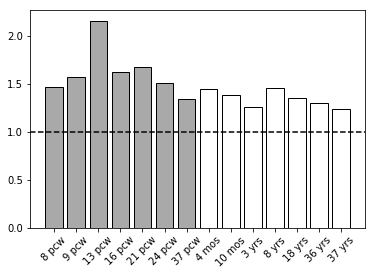

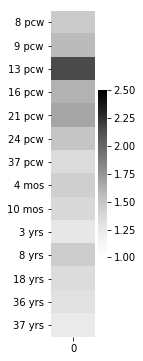

In [211]:
# Plot mean across all tissues
tpmeans = []
for i in range(len(timepoints)):
    tpdata = fcdata[:, i]
    tpmeans.append(np.mean([item for item in tpdata if not np.isnan(item)]))
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(tpmeans)), tpmeans, color=["darkgrey"]*7+["white"]*8, edgecolor="black");
ax.axhline(y=1, linestyle="dashed", color="black")
ax.set_xticks(range(len(tpmeans)))
ax.set_xticklabels(timepoints, rotation=45);

minval = np.mean(tpmeans)
maxval = np.mean(tpmeans)
fig = plt.figure()
fig.set_size_inches((1, 6))
ax = fig.add_subplot(111)
sns.heatmap(np.array(tpmeans).reshape((len(tpmeans), 1)), cmap="Greys", yticklabels=timepoints, ax=ax,
           vmin=1.0, vmax=2.5)
fig.savefig("Figure4_tmpoint_fcs.pdf")

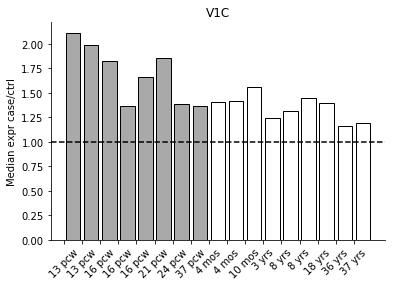

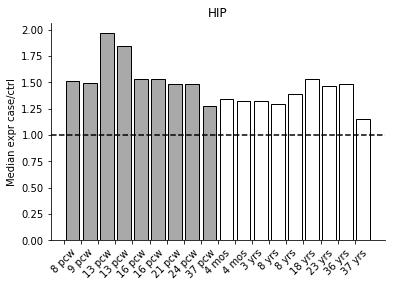

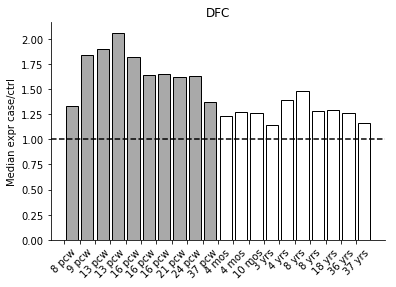

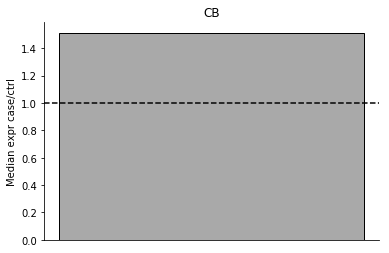

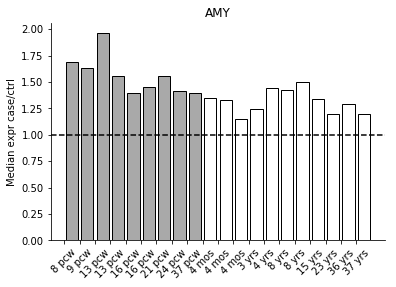

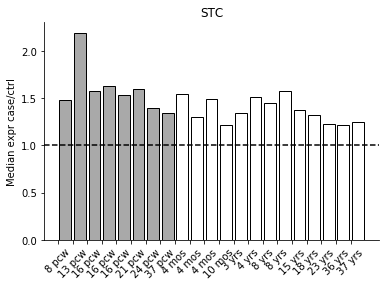

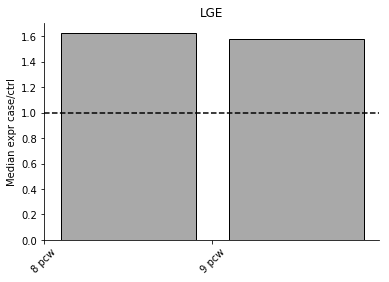

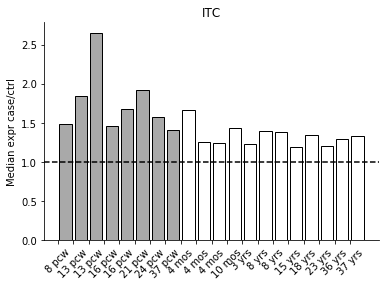

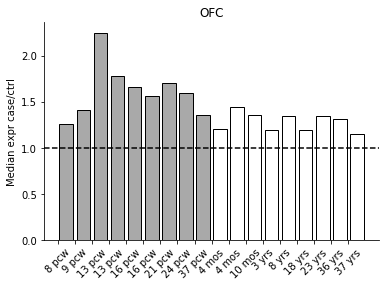

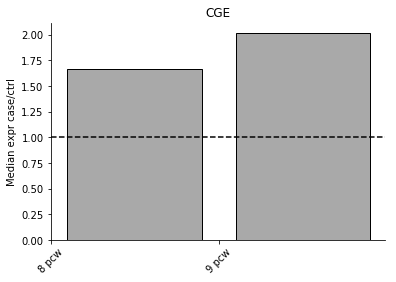

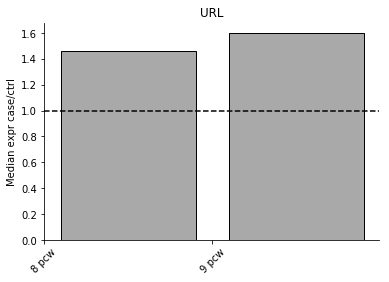

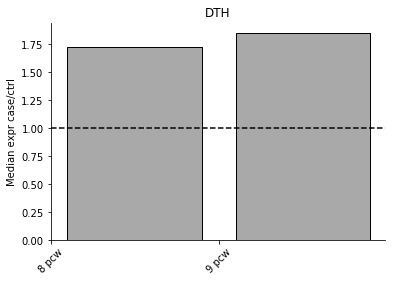

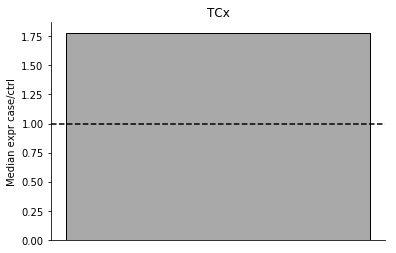

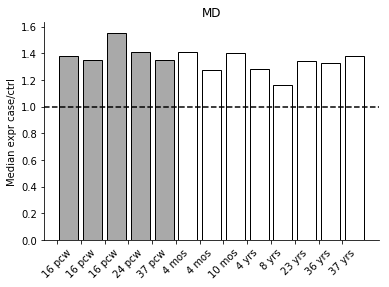

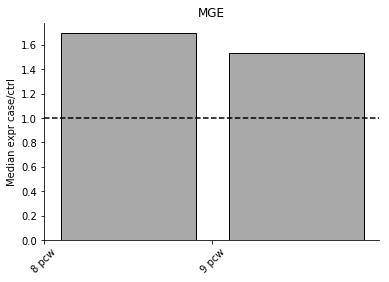

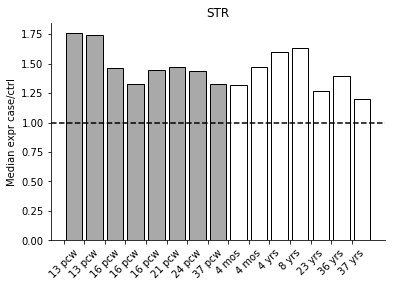

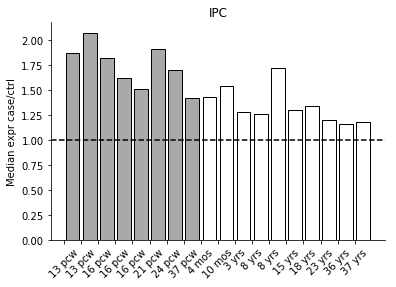

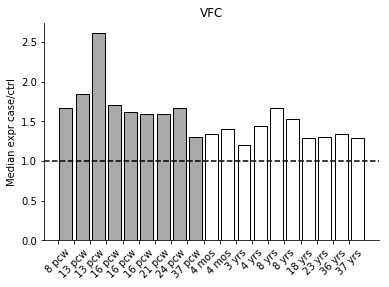

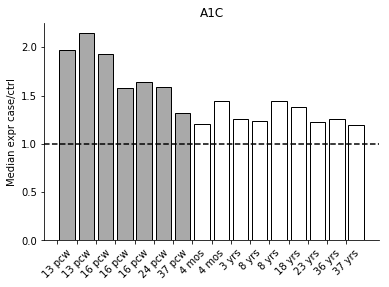

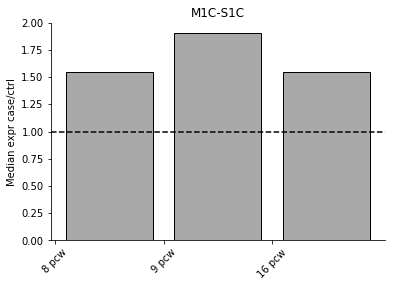

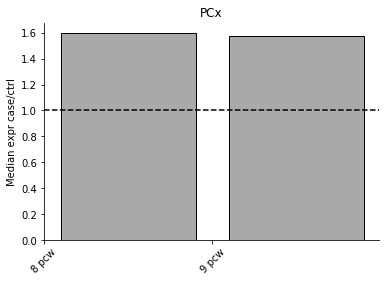

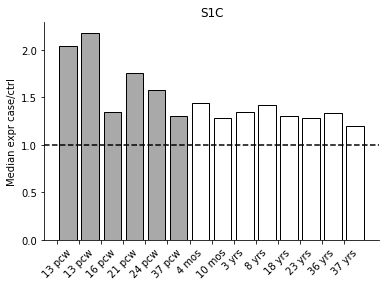

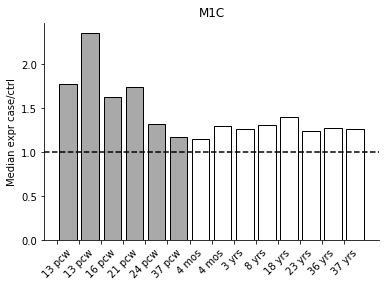

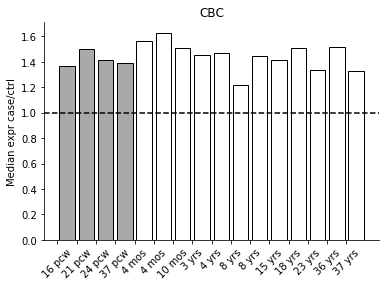

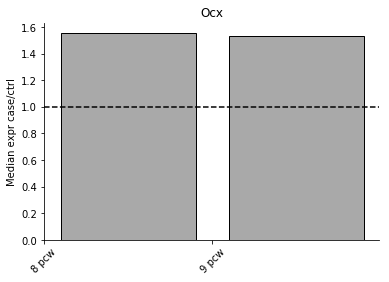

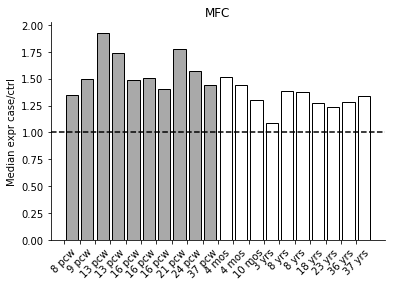

In [13]:
#structure = "DFC"

coldata["color"] = coldata.apply(lambda x: ["darkgrey","white"][int("pcw" not in x["age"])], 1)

for structure in structures:
    coldata["FC"] = coldata.apply(lambda x: x["median_case"]/x["median_ctrl"], 1)
    plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M")]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(range(plotdata.shape[0]), plotdata["FC"], color=list(plotdata["color"]), edgecolor="black")
    ax.set_xticks([item-0.5 for item in range(plotdata.shape[0])])
    ax.set_xticklabels(plotdata["age"], rotation=45);
    ax.set_ylabel("Median expr case/ctrl")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.axhline(y=1, linestyle="dashed", color="black")
    ax.set_title(structure)
    fig.savefig(os.path.join(OUTDIR, "Figure4_Brainspan_%s.pdf"%structure))

In [151]:
np.array([lows, highs])

array([[1.28107299, 1.14977858, 1.63128572, 1.43269205, 1.02501336,
        1.22911935, 1.39094876, 1.19621419, 1.22359367, 1.24718945,
        1.2960486 , 1.29692757, 1.33635149, 1.14725549, 1.33455262,
        1.24974663, 2.01375487, 1.85610371, 2.34637904, 2.00189582,
        1.55362308, 2.14168974, 2.06165289, 1.77060916, 1.90225112,
        1.84774964, 2.01961719, 1.98464251, 1.98104131, 1.9975756 ,
        2.15279325, 1.83479786],
       [0.8963501 , 0.96101714, 1.06719373, 0.95184827, 0.87600312,
        1.01630669, 1.01097214, 0.92238253, 0.9072728 , 0.98536173,
        0.93097887, 0.8914457 , 0.98875926, 0.87778637, 1.06225239,
        0.91455241, 1.14203622, 1.2201385 , 1.38233497, 1.1403885 ,
        1.34620168, 1.23263201, 1.26331836, 1.1868824 , 1.33507114,
        1.25502396, 1.07538627, 1.18802152, 1.15143919, 1.24015852,
        1.10042088, 1.1147651 ]])

8 pcw
(59.68682861372412, 5.909273570778429e-07)
9 pcw
(50.2580234309247, 2.392714827216367e-07)
13 pcw
(129.0912199377901, 6.278198857545824e-15)
16 pcw
(110.63040567253762, 1.3699636951922735e-10)
21 pcw
(108.20572612312728, 2.27624539842126e-11)
24 pcw
(105.62319217966686, 8.502030392374363e-10)
37 pcw
(95.78348699107833, 2.7921625116998487e-08)
4 mos
(101.93458055028877, 3.1973020445830563e-09)
10 mos
(65.61506634656945, 9.309916603609527e-07)
3 yrs
(108.17402711395131, 2.304019560160198e-11)
8 yrs
(100.04901853552603, 6.248602524327828e-09)
18 yrs
(98.06131339021726, 2.690884136800547e-10)
36 yrs
(90.69066859276319, 1.6079445335151976e-07)
37 yrs
(98.095547701582, 1.2444281097788667e-08)


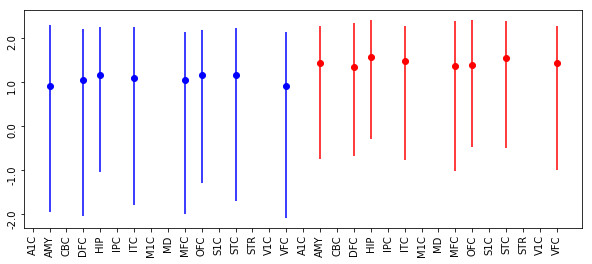

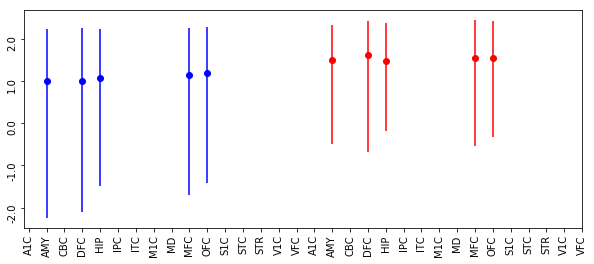

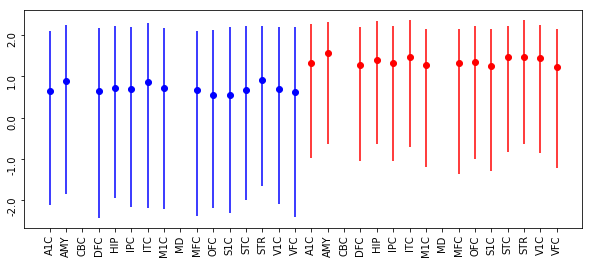

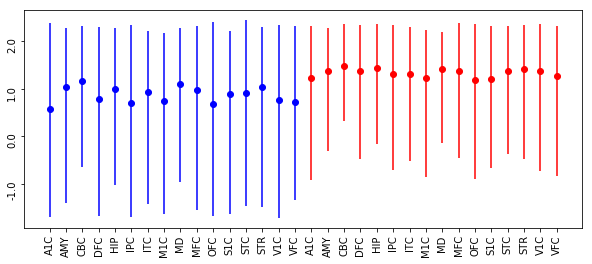

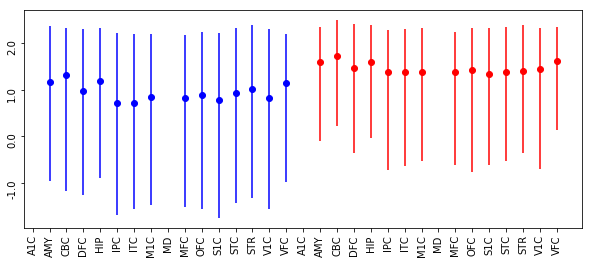

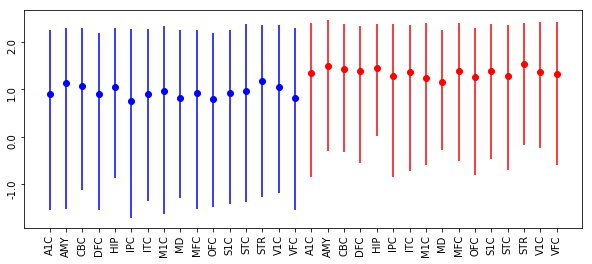

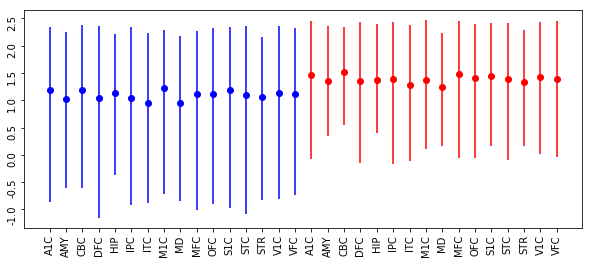

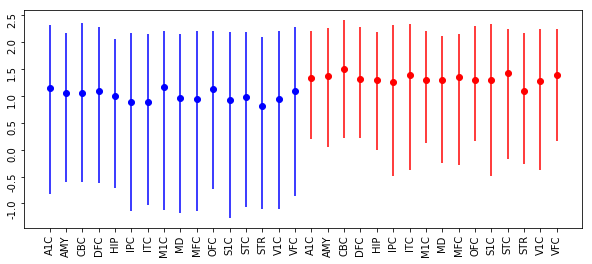

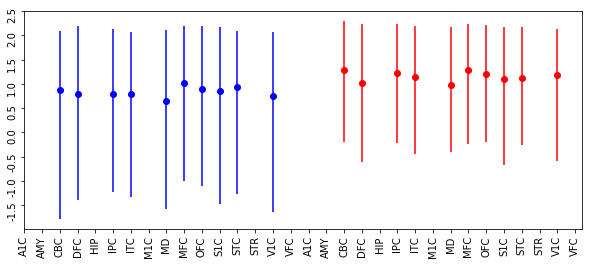

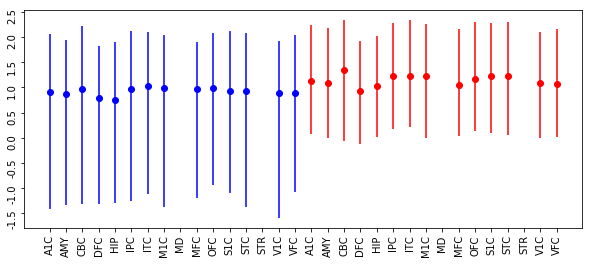

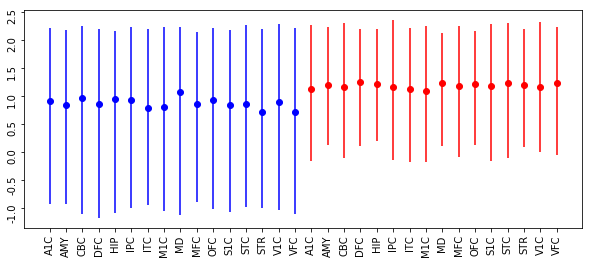

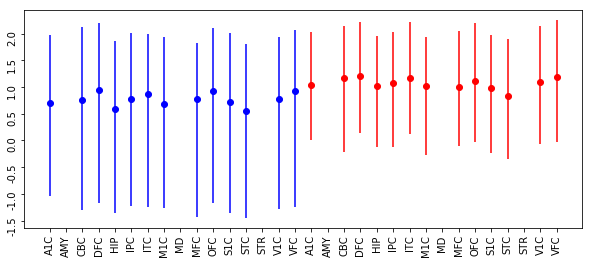

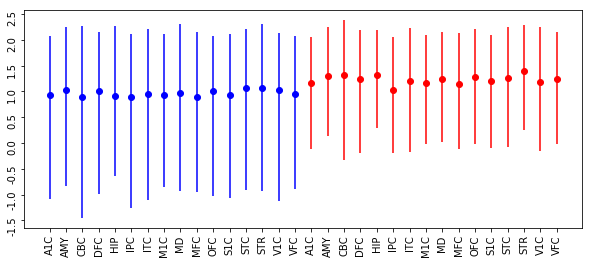

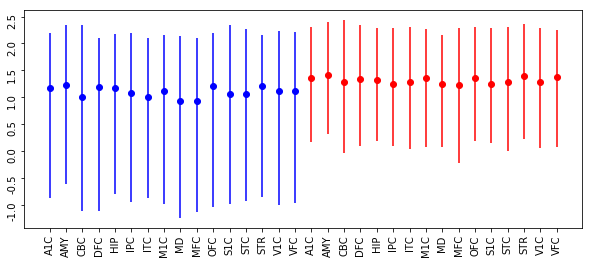

In [195]:
tpvals = []

for timepoint in timepoints:
    meds_case = []
    lows_case = []
    highs_case = []
    meds_ctrls = []
    lows_ctrls = []
    highs_ctrls = []

    positions_case=[]
    positions_ctrls=[]

    colors = []
    pos = 0
    
    pvals = []
    
    # Then controls
    for structure in structures:
        positions_ctrls.append(pos)
        colors.append("blue")
        pos += 1
        try:
            col = plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M") &
                           (coldata["age"]==timepoint)]["column_num"].values[0]
        except:
            meds_ctrls.append(np.nan)
            lows_ctrls.append(np.nan)
            highs_ctrls.append(np.nan)
            continue
        expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)
        meds_ctrls.append(np.median(expr_ctrls))
        lows_ctrls.append(np.median(expr_ctrls)-np.percentile(expr_ctrls, q=25))
        highs_ctrls.append(np.percentile(expr_ctrls, q=75)-np.median(expr_ctrls))

    # First cases
    for structure in structures:
        positions_case.append(pos)
        colors.append("red")
        pos += 1
        try:
            col = plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M") &
                           (coldata["age"]==timepoint)]["column_num"].values[0]
        except:
            meds_case.append(np.nan)
            lows_case.append(np.nan)
            highs_case.append(np.nan)
            continue
        expr_cases = np.log(brainspan.loc[genes_cases, col]+0.01)
        expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)

        meds_case.append(np.median(expr_cases))
        lows_case.append(np.median(expr_cases)-np.percentile(expr_cases, q=25))
        highs_case.append(np.percentile(expr_cases, q=75)-np.median(expr_cases))

        pvals.append(scipy.stats.mannwhitneyu(expr_cases, expr_ctrls, alternative="greater")[1])
        
    # Now plot
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(111)
    ax.errorbar(positions_case, meds_case, fmt="o", color="red", yerr=[lows_case, highs_case])
    ax.errorbar(positions_ctrls, meds_ctrls, fmt="o", color="blue", yerr=[lows_ctrls, highs_ctrls])
    ax.set_xticks(positions_case+positions_ctrls)
    ax.set_xticklabels(structures*2, rotation=90)
    ax.set_yticklabels(ax.get_yticks(), rotation=90)
    fig.savefig("Figure4_lineplot_%s.pdf"%timepoint)

    # Get fisher p-value
    print(timepoint)
    print(scipy.stats.combine_pvalues(pvals))
    tpvals.append(scipy.stats.combine_pvalues(pvals)[1])


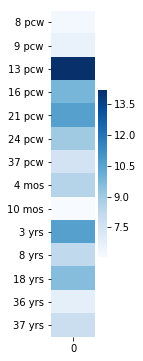

In [197]:
fig = plt.figure()
fig.set_size_inches((1, 6))
ax = fig.add_subplot(111)
sns.heatmap(-1*np.log10(np.array(tpvals)).reshape((len(tpvals), 1)), cmap="Blues", yticklabels=timepoints, ax=ax)
fig.savefig("Figure4_tmpoint_pvals.pdf")

A1C
[81, 113, 406]
AMY
[78, 109]
CBC
[415]
DFC
[88, 107, 411]
HIP
[82, 111, 403]
IPC
[87, 112, 413]
ITC
[89, 110, 407]
M1C
[77, 119, 404]


/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


MD
[]
MFC
[84, 117, 409]
OFC
[86, 116, 414]
S1C
[79, 106, 412]
STC
[85, 410]
STR
[76, 115]
V1C
[80, 118, 405]
VFC
[83, 114, 408]


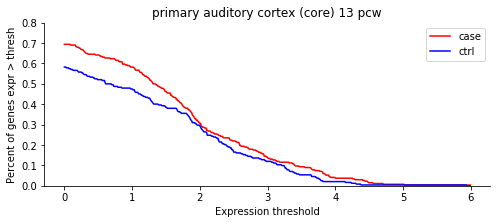

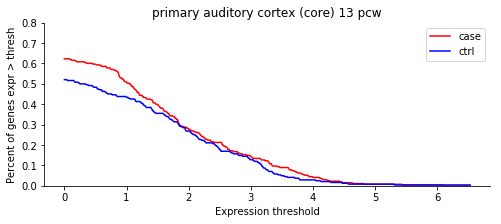

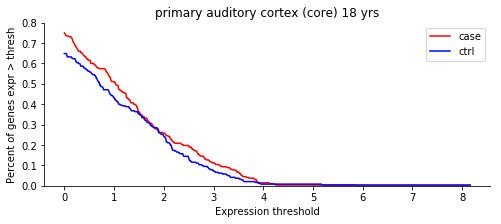

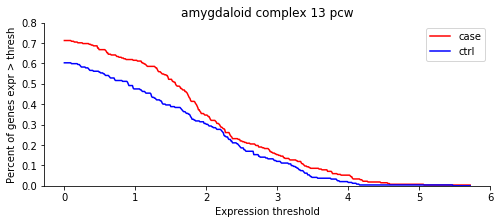

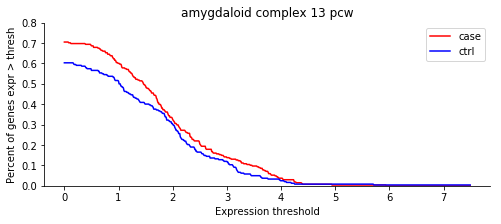

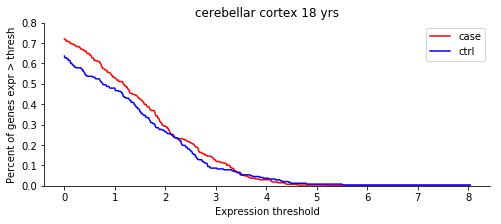

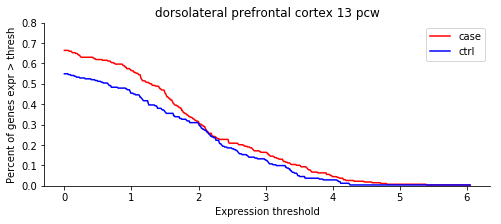

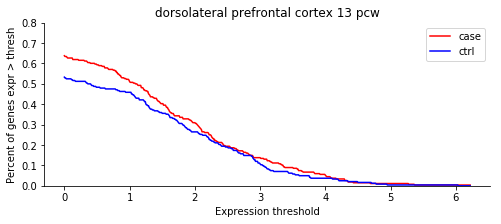

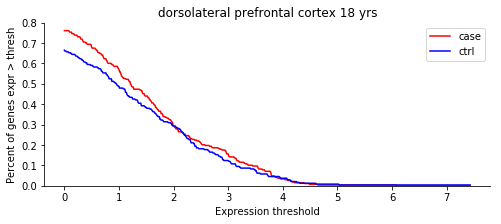

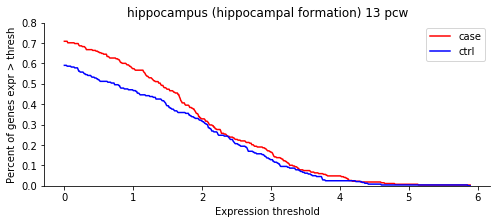

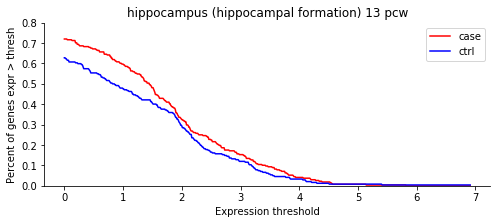

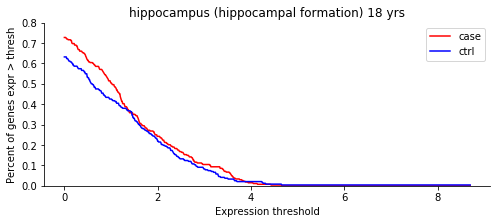

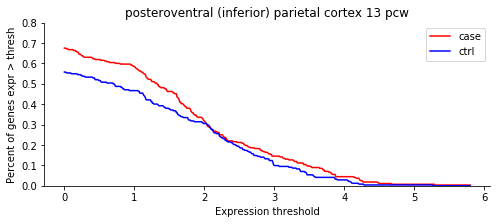

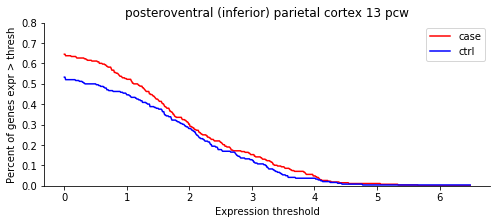

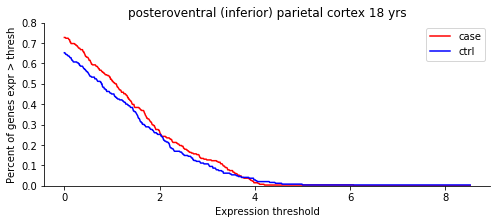

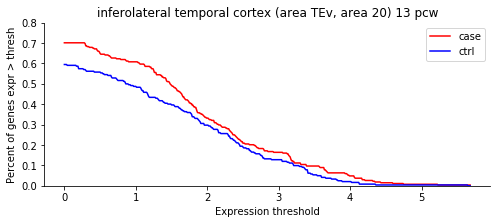

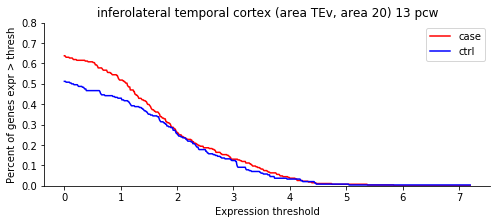

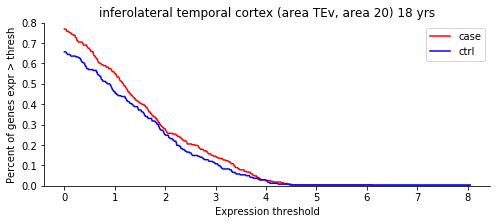

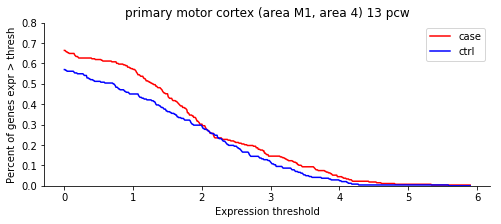

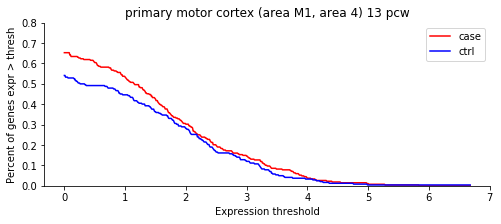

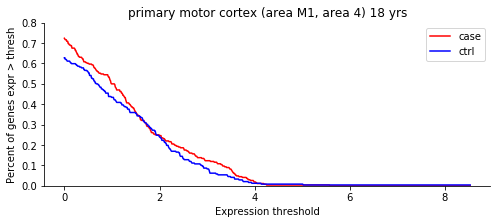

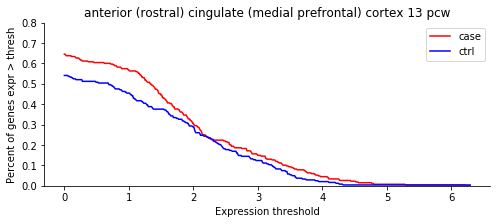

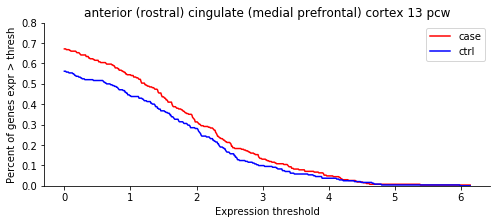

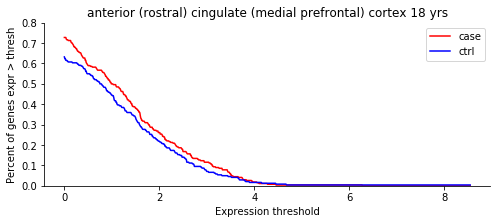

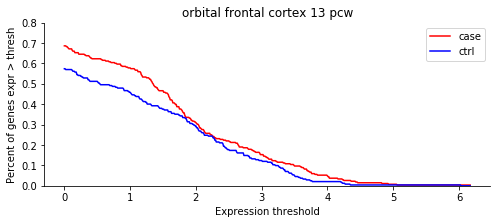

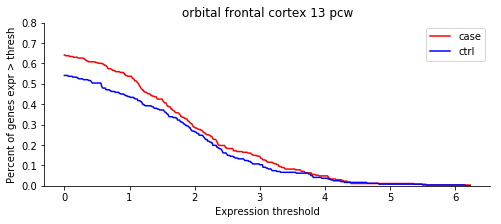

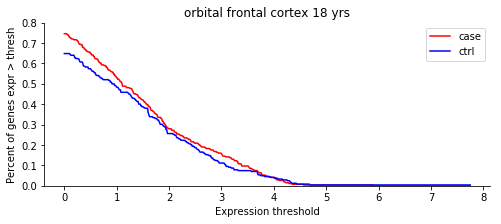

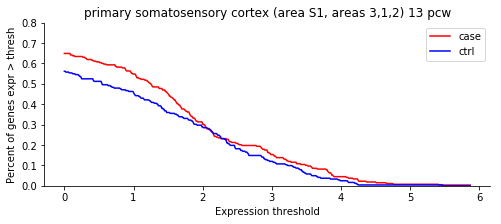

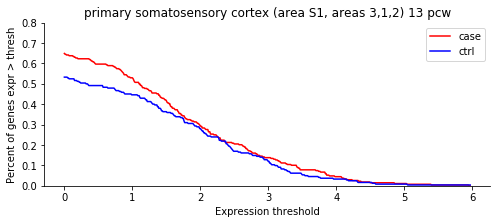

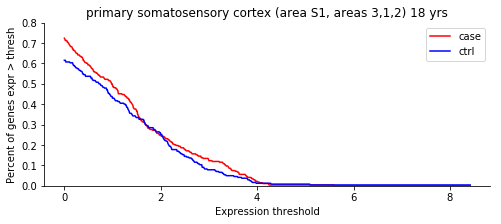

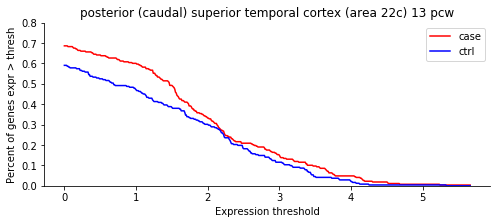

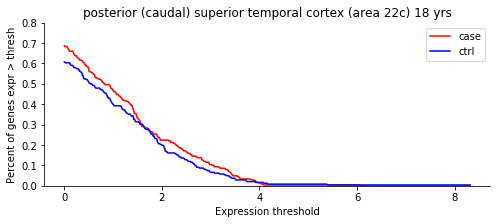

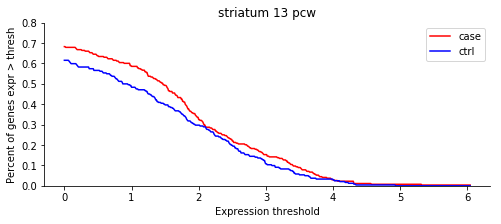

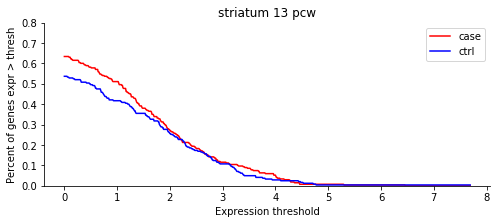

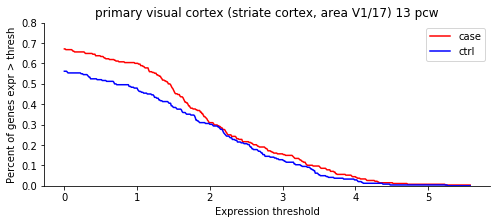

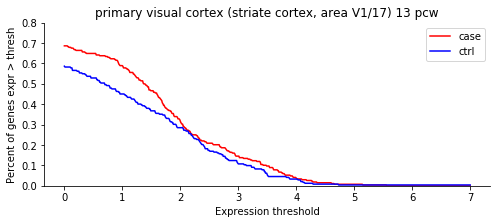

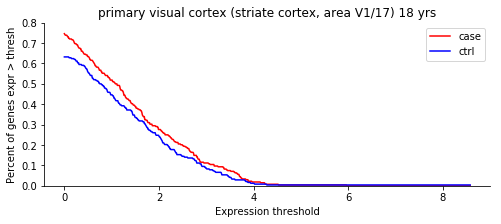

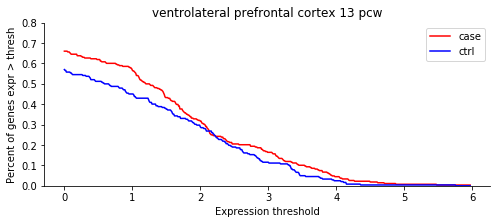

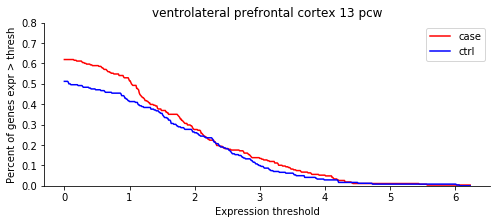

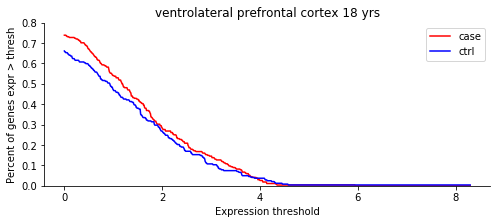

In [79]:

for structure in structures:
    # Get cols for structure, 2 time points
    cols = list(coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M") & 
                    (coldata["age"].apply(lambda x: x in ["13 pcw", "18 yrs"]))]["column_num"]) 
    print(structure)
    print(cols)
    for col in cols:
        fig = plt.figure()
        fig.set_size_inches((8, 3))
        ax = fig.add_subplot(111)

        expr_cases = np.log(brainspan.loc[genes_cases, col]+0.01)
        expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)

        xvals = np.arange(0, max(max(expr_cases), max(expr_ctrls)), 0.01)
        ecdf_cases = []
        ecdf_ctrls = []
        for val in xvals:
            ecdf_cases.append(len([item for item in expr_cases if item >= val])*1.0/len(expr_cases))
            ecdf_ctrls.append(len([item for item in expr_ctrls if item >= val])*1.0/len(expr_ctrls))

        ax.plot(xvals, ecdf_cases, color="red", label="case")
        ax.plot(xvals, ecdf_ctrls, color="blue", label="ctrl")

        x = coldata[coldata["column_num"]==col]
        ax.set_title(x["structure_name"].values[0] + " " + x["age"].values[0])
        ax.set_xlabel("Expression threshold")
        ax.set_ylabel("Percent of genes expr > thresh")
        ax.set_ylim(bottom=0, top=0.8)
        ax.legend(loc="upper right")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
        fig.savefig(os.path.join(OUTDIR, "Figure4_Brainspan_%s_%s.pdf"%(structure, col)))

# Supplementary Fig. 13: GTEx eSTR

Adipose-Subcutaneous


/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MannwhitneyuResult(statistic=6916689.0, pvalue=0.5599766627402993)
0.3355285465169736
3779
3668
Adipose-Visceral
MannwhitneyuResult(statistic=6810006.0, pvalue=0.5315747046442388)
0.34098235234152185
3754
3632
Artery-Aorta
MannwhitneyuResult(statistic=6877250.0, pvalue=0.06609515082824954)
0.438290249466215
3723
3621
Artery-Tibial
MannwhitneyuResult(statistic=6905214.0, pvalue=0.11480371244383147)
0.3315660684143576
3743
3631
Brain-Caudate
MannwhitneyuResult(statistic=6768328.0, pvalue=0.03864068998716572)
0.04563154414764396
3698
3575
Brain-Cerebellum
MannwhitneyuResult(statistic=6516052.0, pvalue=0.5055329268826749)
0.41518483019095137
3680
3542
Cells-Transformedfibroblasts
MannwhitneyuResult(statistic=6411703.0, pvalue=0.40942326823861985)
0.3515543974243835
3642
3510
Esophagus-Mucosa
MannwhitneyuResult(statistic=6877760.0, pvalue=0.28271058857800857)
0.22612179718741848
3749
3641
Esophagus-Muscularis
MannwhitneyuResult(statistic=6877622.0, pvalue=0.6733354997439137)
0.4783231759717

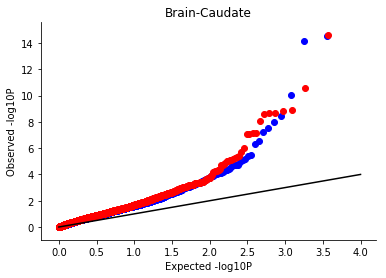

In [10]:
# Load gtex data
# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
def concat(x):
    return ",".join(x)

TISSUES=["Adipose-Subcutaneous",
         "Adipose-Visceral",
         "Artery-Aorta",
         "Artery-Tibial",
         "Brain-Caudate",
         "Brain-Cerebellum",
         "Cells-Transformedfibroblasts",
         "Esophagus-Mucosa",
         "Esophagus-Muscularis",
         "Heart-LeftVentricle",
         "Lung", 
         "Muscle-Skeletal", 
         "Nerve-Tibial",
         "Skin-NotSunExposed",
         "Skin-SunExposed", 
         "Thyroid",
         "WholeBlood"]

pvals = []

def GetXvals(size):
    # Get quantiles of uniform 0,1
    # return sorted -1*log10
    step = 1.0/size
    vals = np.array([step*(i+1) for i in range(size)])
    return -1*np.log10(vals)
    
for tissue in TISSUES:
    print(tissue)
    GTEXFILE = "/storage/mgymrek/gtex-estrs/revision/mastertables/%s_master.tab"%tissue
    gtex = pd.read_csv(GTEXFILE, sep="\t")
    gtex["chrom"] = gtex["chrom"].apply(lambda x: GetChrom(x))
    gtex["pos_hg19"] = gtex["str.start"].apply(int)
    gtex = gtex[~np.isnan(gtex["linreg.pval"])]
    gtex["linreg.beta"] = gtex["linreg.beta"].apply(abs)
    gtex = gtex.groupby(["chrom","pos_hg19","str.motif.forward"], as_index=False).agg({"linreg.pval": np.min, "linreg.beta": np.max, "gene.name": concat})

    merged = pd.merge(gtex, data, on=["chrom","pos_hg19"])
    #merged = merged[merged["str.motif.forward"].apply(len)>1]

    aff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_aff"]>0) & (merged["mut_unaff"]==0)].sort_values("linreg.pval")["linreg.pval"])))
    unaff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_unaff"]>0)& (merged["mut_aff"]==0)].sort_values("linreg.pval")["linreg.pval"])))

    print(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater"))
    print(scipy.stats.ttest_ind(aff_pvals, unaff_pvals)[1]/2)
          
    print(len(aff_pvals))
    print(len(unaff_pvals))
    pvals.append(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater")[1])
    if tissue == "Brain-Caudate":
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(GetXvals(len(unaff_pvals)), unaff_pvals, color="blue")
        ax.scatter(GetXvals(len(aff_pvals)), aff_pvals, color="red")
        ax.plot([0,4],[0,4], color="black")
        ax.set_title(tissue)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
        ax.set_xlabel("Expected -log10P")
        ax.set_ylabel("Observed -log10P")
        fig.savefig(os.path.join(OUTDIR, "Figure4_eSTR_QQ_%s.pdf"%tissue))

In [ ]:
# Get HDAC2 info
GTEXFILE = "/storage/mgymrek/gtex-estrs/revision/mastertables/%s_master.tab"%"Brain-Caudate"
gtex = pd.read_csv(GTEXFILE, sep="\t")
gtex["chrom"] = gtex["chrom"].apply(lambda x: GetChrom(x))
gtex["pos_hg19"] = gtex["str.start"].apply(int)
merged = pd.merge(gtex, data, on=["chrom","pos_hg19"])

# Figure 4c: HDAC2 allele frequencies

In [11]:
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["count"]),"count"] = 0

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys


In [12]:
adata[adata["pos"]==113970946][["child_gt","mat_gt","pat_gt"]]

,child_gt,mat_gt,pat_gt
146272,"5,8","8,8","8,8"


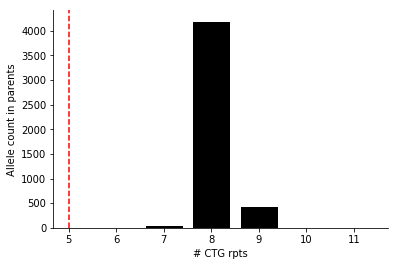

In [13]:
freqs = afreq[afreq["pos"]==113970946].copy()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(freqs["newallele"], freqs["count"], color="black", edgecolor="white");
ax.axvline(x=5, linestyle="dashed", color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xlabel("# CTG rpts")
ax.set_ylabel("Allele count in parents")
fig.savefig(os.path.join(OUTDIR, "Figure4_HDAC2_AlleleCounts.pdf"))

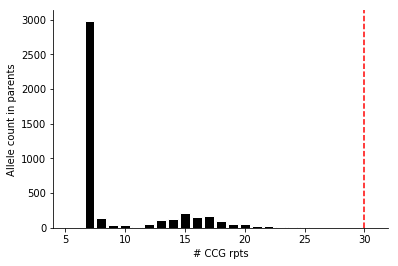

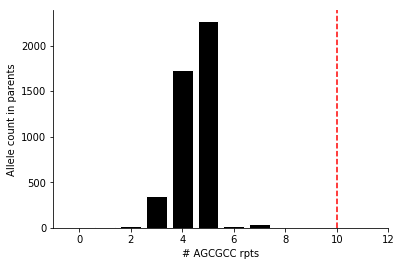

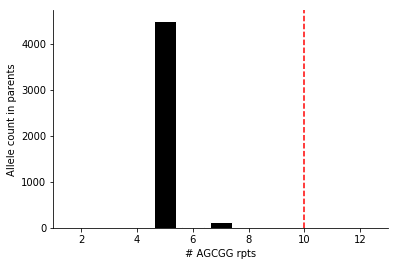

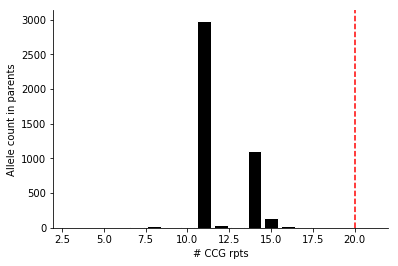

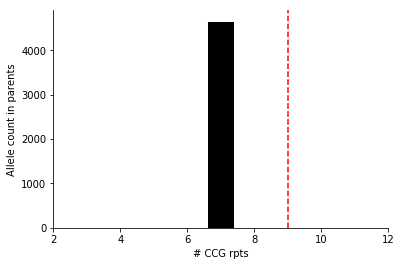

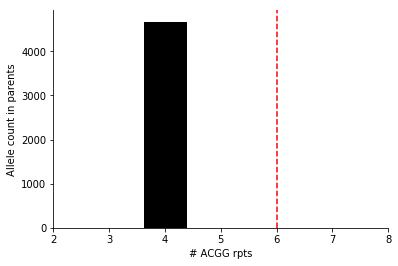

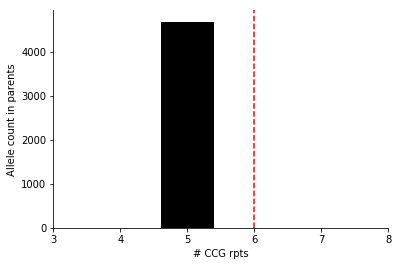

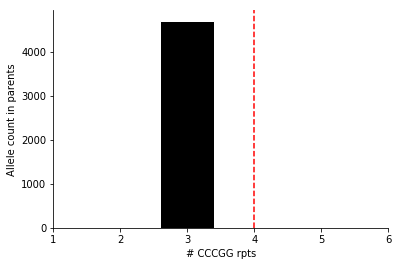

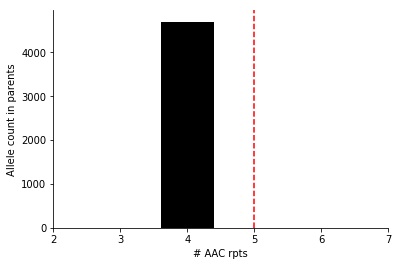

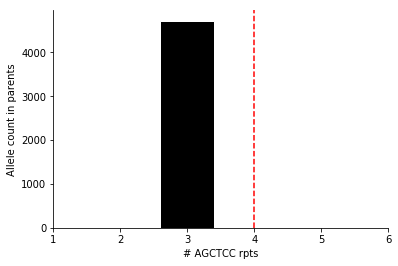

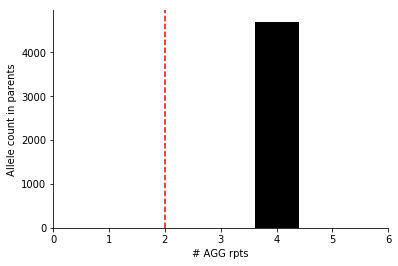

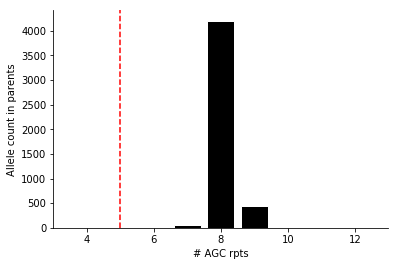

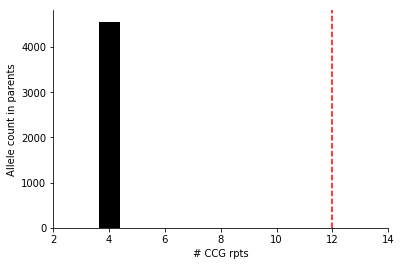

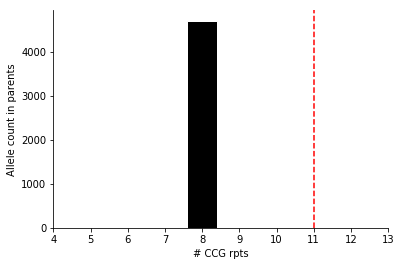

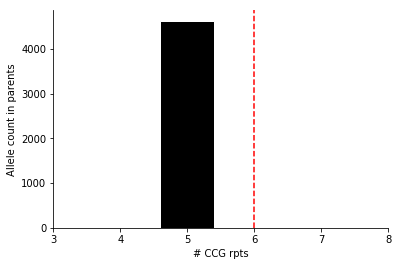

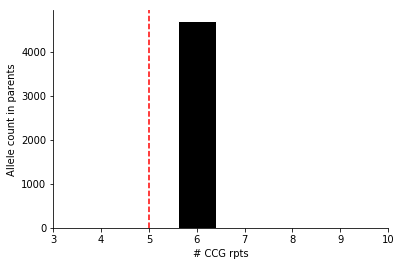

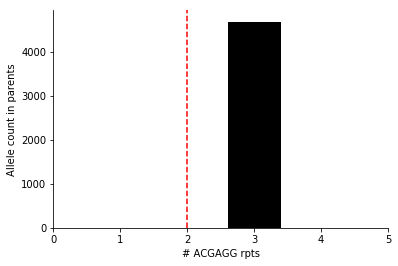

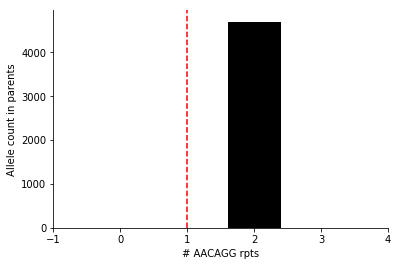

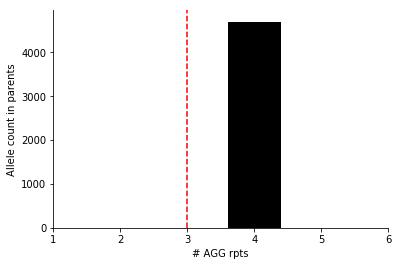

In [14]:
fdata[(fdata["phenotype"]==1) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)[["chrom","pos","newallele","child_gt","mat_gt","pat_gt","gene-coding","TSS_GENE"]]

proband_pos = fdata[(fdata["phenotype"]==2) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)["pos"]
sibling_pos = fdata[(fdata["phenotype"]==1) & (fdata["count"]==0) & 
      ((fdata["FEATURE-CODING"]>0) | (fdata["FEATURE-UTR5"]>0 | (fdata["FEATURE-PROMOTER5kb"]>0)))].sort_values("mutsize", ascending=False)["pos"]

for pos in list(proband_pos)+list(sibling_pos):
    freqs = afreq[afreq["pos"]==pos].copy()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(freqs["newallele"], freqs["count"], color="black", edgecolor="white");
    newallele = fdata[(fdata["pos"]==pos) & (fdata["count"]==0)]["newallele"].values[0]
    motif = fdata[(fdata["pos"]==pos)]["motif"].values[0]
    ax.axvline(x=newallele, linestyle="dashed", color="red")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("# %s rpts"%motif)
    ax.set_ylabel("Allele count in parents")
    minallele = min([newallele]+list(freqs["newallele"]))
    maxallele = max([newallele]+list(freqs["newallele"]))
    ax.set_xlim(left=minallele-2, right=maxallele+2)
    if pos in list(proband_pos): name = "proband"
    else: name = "sibling"
    fig.savefig(os.path.join(OUTDIR, "SuppFig_%s_%s_AlleleCounts.pdf"%(pos, name)))